In [1]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import wofz, gamma
from sklearn.metrics import r2_score

# figure save option
save_option = True
figsavepath = "../Figures/FigureS19_XRC100-400.svg"

# input the folder path
folder_path = '../Data/FigureS19_XRC100-400'
csv_list = glob.glob(f'{folder_path}/*.csv')
csv_list.sort()

name_list, df_list = [], []
for i in range(len(csv_list)):
    csv = csv_list[i]
    name = os.path.basename(csv)
    rows = 0
    while True:
        try:
            df = pd.read_csv(csv,skiprows=rows)
            x = df['Angle'].to_list()
            break
        except:
            rows += 1
        if rows == 1000:
            break
    name_list.append(name)
    df_list.append(df)
    print(f'{i}: {name}')

/Users/yukiharuta/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


0: 231010_AY4_0.2_11-100omega.csv
1: 231010_AY4_0.2_11-200omega.csv
2: 231010_AY4_0.2_11-300omega.csv
3: 231010_AY4_0.2_11-400omega.csv



0: 231010_AY4_0.2_11-100omega.csv
max intensity 5216.0
A: 67623.0, FHWM: 15.73, R2: 0.994
7.713%

1: 231010_AY4_0.2_11-200omega.csv
max intensity 4764.0
A: 58270.0, FHWM: 14.01, R2: 0.997
8.176%

2: 231010_AY4_0.2_11-300omega.csv
max intensity 1273.0
A: 11457.0, FHWM: 11.85, R2: 0.995
11.111%

3: 231010_AY4_0.2_11-400omega.csv
max intensity 1231.0
A: 12747.0, FHWM: 13.83, R2: 0.995
9.657%


/var/folders/n_/_z_q62kx279gp1tfsgqh78s40000gn/T/ipykernel_31629/1407359871.py:13: RuntimeWarning: invalid value encountered in sqrt
  y = y0 + A*(2*gamma(mu)*np.sqrt(2**(1/mu)-1))/np.sqrt(np.pi)/gamma(mu-0.5)/w*(1+4*(2**(1/mu)-1)/w/w*(x-xc)**2)**(-mu)
/var/folders/n_/_z_q62kx279gp1tfsgqh78s40000gn/T/ipykernel_31629/1407359871.py:13: RuntimeWarning: invalid value encountered in power
  y = y0 + A*(2*gamma(mu)*np.sqrt(2**(1/mu)-1))/np.sqrt(np.pi)/gamma(mu-0.5)/w*(1+4*(2**(1/mu)-1)/w/w*(x-xc)**2)**(-mu)


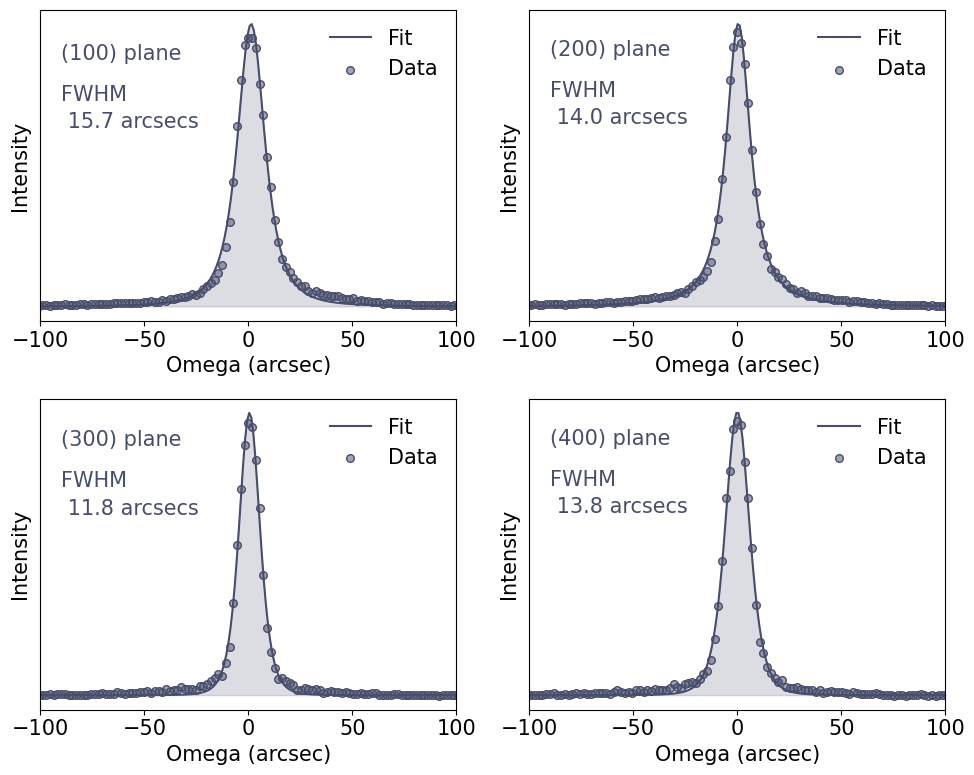

In [2]:
plot_id = np.arange(0,len(df_list),1)

# plot the fitted function and the data
plt.rcParams["font.size"] = 15
fig, axes = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(10,8))
color = '#474D6B'
labels = ['(100)', '(200)', '(300)', '(400)']
colors = ['#CF597E', '#BE577B', '#AD5679', '#9C5476', '#8B5374', '#7A5172', '#69506F', '#584E6D', '#474D6B']

# define the PearsonVII function for the fitting of rocking curves
# https://www.originlab.com/doc/Origin-Help/PearsonVII-FitFunc
def PearsonVII(x, xc, y0, A, mu, w):
    y = y0 + A*(2*gamma(mu)*np.sqrt(2**(1/mu)-1))/np.sqrt(np.pi)/gamma(mu-0.5)/w*(1+4*(2**(1/mu)-1)/w/w*(x-xc)**2)**(-mu)
    return y

i = 0
for plot in plot_id:
    print(f'\n{plot}: {name_list[plot]}')
    x = df_list[plot]['Angle'].to_list()
    y = df_list[plot][' Intensity'].to_list()
    I0 = max(y)
    print(f'max intensity {I0}')
    # Normilize intensity
    y = [n/max(y) for n in y]
    index = y.index(max(y))
    x = [(n - x[index])*3600 for n in x] # arcsec

    # initial guess for the parameters of the first peak
    xc_guess = 0
    y0_guess = 0
    A_guess = 30
    mu_guess = 1.0
    w_guess = 30

    # define the range of x-values to fit over
    x_min = np.min(x)
    x_max = np.max(x)

    try:
        # fit the PearsonVII function to the data
        popt, pcov = curve_fit(PearsonVII, x, y, p0=[xc_guess, y0_guess, A_guess, mu_guess, w_guess])
        X = np.arange(x_min,x_max,1)

        # calculate R-squared value
        y_fit = PearsonVII(x, *popt)
        R2 = r2_score(y, y_fit)

        # Fitted Parameters
        xc_fit, y0_fit, A_fit, mu_fit, w_fit = popt

        # Extract FWHM and FWXM (full-width at X% maximum)
        FWHM = w_fit
        
        # Integral Intensity
        A = sum(y_fit) * I0

        # plot the fitted function and the data
        ax = axes[i//2][i%2]
        ax.plot(X, PearsonVII(X, *popt), color='#474D6B', label='Fit')
        ax.fill_between(X, PearsonVII(X, *popt), color='#474D6B30')
        ax.scatter(x, y, c='#474D6B80',ec='#474D6B', label='Data', s=30)
        ax.legend(frameon=False)
        ax.set_xlabel('Omega (arcsec)')
        ax.set_ylabel('Intensity')
        ax.set_xlim(-100,100)
        ax.set_yticks([])
        ax.text(-90, 0.9, f'({i+1}00) plane', ha='left', va='bottom',color="#474D6B",fontsize=15)
        ax.text(-90, 0.75, f'FWHM', ha='left', va='bottom',color="#474D6B",fontsize=15)
        ax.text(-90, 0.65, f' {FWHM:.1f} arcsecs', ha='left', va='bottom',color="#474D6B",fontsize=15)
        print(f'A: {A:.1f}, FHWM: {FWHM:.2f}, R2: {R2:.3f}')

    except Exception as e:
        print(e)
        FWHM, R2 = 'Fit Fail',None
    
    print(f'{I0/A*100:.3f}%')
    i += 1

if save_option:
    plt.savefig(figsavepath, dpi=1200, bbox_inches='tight', transparent=True)